# Deep learning in genomics - Basic model with PyTorch

This notebook is based on the [jupyter notebook](https://nbviewer.jupyter.org/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [PyTorch](https://pytorch.org) library.

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
import pdb

In [5]:
# fastai version
__version__

'1.0.39.dev0'

# Data setup

## Load data from the web, generate dataframe, and save to disk

In [52]:
import requests

In [53]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [54]:
# get sequence data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [55]:
# check length
len(seq_raw)

2000

2000

In [56]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [57]:
# show head of dataframe
#seq_df.head()

In [58]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [59]:
# get sequence labels from URL
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [60]:
# check length
len(seq_labels)

2000

2000

In [61]:
# setup pandas series
seq_label_series = pd.Series(seq_labels)

In [62]:
# add pandas series to pandas dataframe
seq_df['Target'] = seq_label_series.astype('int')

In [63]:
# show head
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [64]:
# save to csv file
seq_df.to_csv('seq_df.csv')

## Data frame setup

In [6]:
# load csv file into pandas data frame
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [7]:
# show pandas data frame head
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


### Target variables setup

In [8]:
# setup target a
targA = seq_df['Target'].values; targA

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

In [9]:
# setup target b = not(target a)
targB = np.logical_not(seq_df['Target'].values).astype(int); targB

array([1, 1, 1, 0, ..., 0, 1, 0, 0])

In [10]:
# zip together target a and target b to get target
targ = [[a,b] for a, b in zip(targA, targB)]; targ[:4], '...', targ[-4:]#, len(targ)

([[0, 1], [0, 1], [0, 1], [1, 0]], '...', [[1, 0], [0, 1], [1, 0], [1, 0]])

## Dataset setup for training with basic PyTorch

### Setup sqeuence to array function

In [11]:
# open sequence array function
def open_seq_array(seq:str)->List:
    "Return `List` object with np.array created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    
    return enc

In [12]:
# test open sequence function
test_arr = open_seq_array('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC'); test_arr, test_arr.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

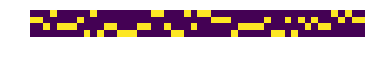

In [13]:
# visualize opened sequence as 2D image
plt.imshow(test_arr)
plt.axis('off');

In [14]:
test_ten = tensor(test_arr).type(torch.float); test_ten

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
# run test data through network
#net_basic(test_ten[None])

### Setup datasets

In [16]:
# generate sequence array float tensor for every sequence in pandas data frame column Sequences (x data)
x = [tensor(open_seq_array(s)).type(torch.float) for s in seq_df['Sequences'].values]; len(x)

2000

In [17]:
# stack all tensors together in a single tensor
x = torch.stack(x); x.shape

torch.Size([2000, 4, 50])

In [18]:
# setup target data floar tensor (y data)
y = tensor(targ).view(-1,2).type(torch.float); y # multi-label
#y = tensor(targA).type(torch.float); y # classification with single label

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]])

In [19]:
# verify total dataset length
len(x), len(y)

(2000, 2000)

In [20]:
# check x and y data
i = 2
x[i], y[i]

(tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
          0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
          0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
          1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]),
 tensor([0., 1.]))

In [21]:
# split dataset into train and valid TensorDataset for NN training
train_ds = TensorDataset(x[:1500],y[:1500]) # FIRST 1500 data points
valid_ds = TensorDataset(x[-500:],y[-500:])

In [84]:
# split dataset into train and valid TensorDataset for NN training
train_ds = TensorDataset(x[500:],y[500:]) # LAST 1500 data points
valid_ds = TensorDataset(x[:500],y[:500])

In [85]:
# verify train and valid dataset length
len(train_ds), len(valid_ds)

(1500, 500)

# Model setup

## Basic model for PyTorch training

In [86]:
# set dropout
drop_p = 0.2

In [87]:
# inplace=True seems to generate problems?

In [96]:
net_basic = nn.Sequential(nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #Debugger() # optional debugger layer
                   )

In [97]:
# check network architecture
net_basic

Sequential(
  (0): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Lambda()
  (3): Dropout(p=0.2)
  (4): Linear(in_features=288, out_features=16, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2)
  (7): Linear(in_features=16, out_features=2, bias=True)
)

In [98]:
# initialize weights with kaiming normal initialization
apply_init(net_basic, nn.init.kaiming_normal_)

# Model training

## Train basic model with PyTorch

In [99]:
# set batch size
bs = 64

In [100]:
# setup DataLoader for NN training from TensorDatasets for NN training
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)

In [101]:
# set optimizer type, parameters, and hyperparameters
opt = optim.SGD(net_basic.parameters(), lr=1e-3, momentum=0.9)

In [102]:
# training loop extended from https://github.com/fastai/fastai_docs/blob/master/dev_nb/mnist_sample.py


# simple loss function for batch
def simple_loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


# simple fit function
def simple_fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    
    epoch_list = []
    train_loss_list = []
    valid_loss_list = []
    acc_list = []
    
    print('epoch\ttrain loss\tvalid loss\taccuaracy')
    
    for epoch in range(epochs):
        
        model.train()
        train_losses, train_nums = zip(*[simple_loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl])
        
        # loss calculation for every epoch
        train_loss = np.sum(np.multiply(train_losses, train_nums)) / np.sum(train_nums)
        train_loss_list.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            valid_losses, valid_nums = zip(*[simple_loss_batch(model, loss_func, xb, yb)
                                for xb,yb in valid_dl])
            
            # calculations for accuracy_thres metric:          
            y_hat = [model(xb) for xb, _ in valid_dl]
            y_true = [yb for _, yb in valid_dl]
            
            
        valid_loss = np.sum(np.multiply(valid_losses, valid_nums)) / np.sum(valid_nums)
        acc = accuracy_thresh(torch.cat(y_hat), torch.cat(y_true))
        
        epoch_list.append(epoch)
        valid_loss_list.append(valid_loss)
        acc_list.append(acc)
        
        print(f'{epoch}\t{train_loss:.6f}\t{valid_loss:.6f}\t{acc.detach().item():.3f}')
    
    # print training (https://matplotlib.org/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py)
    #pdb.set_trace()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(valid_loss_list, label='valid loss')
    plt.legend()
    plt.show()

epoch	train loss	valid loss	accuaracy
0	0.804541	0.732663	0.442
1	0.736487	0.709564	0.467
2	0.715503	0.697698	0.494
3	0.704023	0.694342	0.497
4	0.695443	0.693484	0.506
5	0.695747	0.691172	0.518
6	0.693234	0.690179	0.512
7	0.689151	0.689102	0.522
8	0.692404	0.688645	0.514
9	0.687184	0.687437	0.531
10	0.691757	0.686119	0.546
11	0.685319	0.685073	0.568
12	0.684653	0.683993	0.570
13	0.681419	0.682848	0.572
14	0.682558	0.681412	0.576
15	0.678185	0.679701	0.574
16	0.679829	0.679035	0.582
17	0.680432	0.677309	0.582
18	0.680749	0.676479	0.583
19	0.674447	0.674404	0.589
20	0.673581	0.673439	0.598
21	0.674626	0.671766	0.595
22	0.673354	0.669067	0.596
23	0.666673	0.667255	0.604
24	0.671426	0.665430	0.609
25	0.668985	0.663827	0.614
26	0.667549	0.662952	0.631
27	0.660405	0.660248	0.635
28	0.661176	0.657947	0.637
29	0.653916	0.655562	0.635
30	0.649944	0.652407	0.639
31	0.654169	0.649733	0.645
32	0.649215	0.647483	0.648
33	0.645647	0.644580	0.654
34	0.645629	0.642298	0.664
35	0.642573	0.638919	0.665


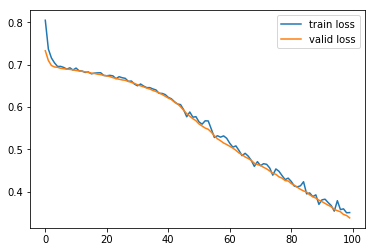

In [103]:
simple_fit(100, net_basic, F.binary_cross_entropy_with_logits, opt, train_dl, valid_dl)